In [1]:
using CSV
using DataFrames
using Query
using Statistics
using Random
using PyPlot
using StatsPlots
using GLM
using DecisionTree
using LinearAlgebra
using ScikitLearn
@sk_import linear_model: LogisticRegression


Random.seed!(2);

┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278
┌ Warning: Module Distributions with build ID 87506549864118 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
│   exception = ErrorException("Required dependency Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5] failed to load from a cache file.")
└ @ Base loading.jl:1042
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1278
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
│   exception = ErrorException("Requi

In [2]:
data = CSV.File("SpeedDatingData.csv") |> DataFrame;

In [3]:
#FILTER DATA SO ALL POINTS HAVE ATTRACTIVENESS
println(size(data))

selected = [:gender, :attr_o, :age_o, :sinc_o, :intel_o, :fun_o, :amb_o, :shar_o, :samerace, :age]

for col in selected
    data = data[.!ismissing.(data[!,col]),:];
    end


for col in filter(col -> (col!=:dec_o && col!=:gender && col!=:samerace), selected)
    data[col] = convert.(Float64, data[col]);
    end

for col in filter(col -> (col==:dec_o || col==:gender || col==:samerace), selected)
    data[col] = convert.(Bool, data[col]);
    end


println(size(data))

(8378, 195)
(6880, 195)


In [4]:
# Calculate new average features
## avg_attr_others measures average attractiveness rating given by individual for others
## avg_attr_self measures average attractiveness rating given to individual by others
## count measures number of pairing individual was in
avgs = data |>
    @groupby(_.iid)|>
    @map({iid = key(_), avg_attr_others=mean(_.attr_o)})|>
    DataFrame

df = join(avgs, data, on = :iid)

avgs = df |>
    @groupby(_.pid)|>
    @map({iid = key(_), avg_attr_self=mean(_.attr_o)})|>
    DataFrame

df = join(avgs, df, on= :iid);

count =data |>
    @groupby(_.iid)|>
    @map({iid = key(_),   count = length(_)}) |>
    DataFrame

df = join(count, df, on=:iid);
df[:random] = rand(1:10, size(df, 1));
df[:agediff] = df[:age].-df[:age_o];

In [5]:
# Features we are interested in for initial exploration
selected = [:gender, :avg_attr_self, :avg_attr_others, :dec_o, :attr_o, :age_o, :sinc_o, :intel_o]
selected = append!(selected, [:fun_o, :amb_o, :shar_o, :samerace, :count, :age, :agediff, :random])
just_attr = df[selected];

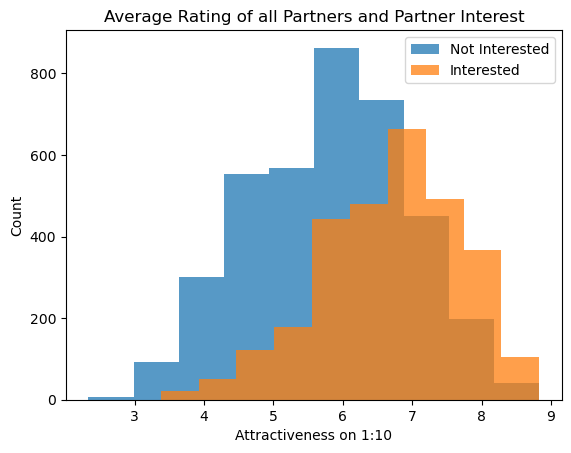

PyObject Text(24.000000000000007, 0.5, 'Count')

In [6]:
plt2 = PyPlot.hist(just_attr[:avg_attr_others][just_attr[:dec_o].==0], label="Not Interested", alpha=.75)
plt1 = PyPlot.hist(just_attr[:avg_attr_others][just_attr[:dec_o].==1], label="Interested", alpha=.75)
legend()
title("Average Rating of all Partners and Partner Interest")
xlabel("Attractiveness on 1:10")
ylabel("Count")

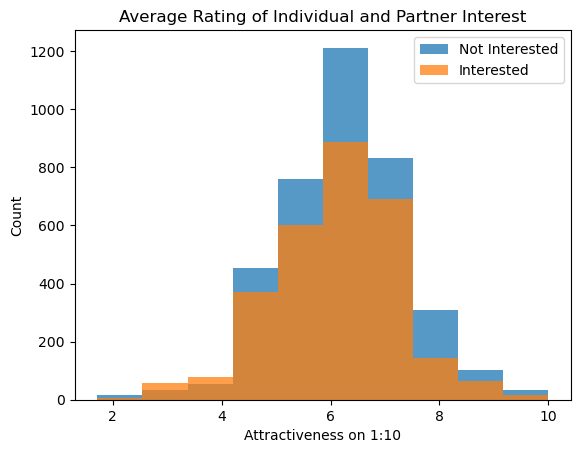

PyObject Text(24.0, 0.5, 'Count')

In [7]:
plt2 = PyPlot.hist(just_attr[:avg_attr_self][just_attr[:dec_o].==0], label="Not Interested", alpha=.75)
plt1 = PyPlot.hist(just_attr[:avg_attr_self][just_attr[:dec_o].==1], label="Interested", alpha=.75)
legend()
title("Average Rating of Individual and Partner Interest")
xlabel("Attractiveness on 1:10")
ylabel("Count")

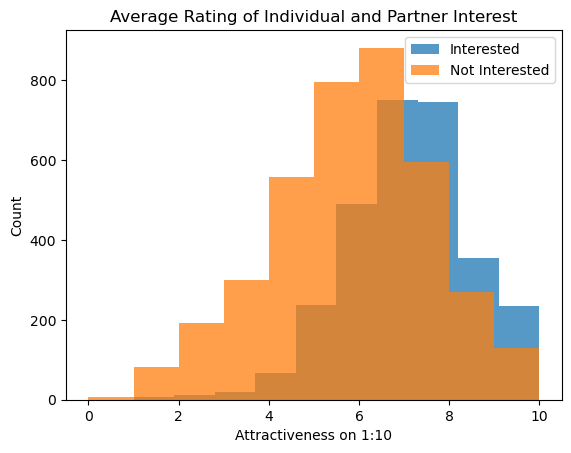

PyObject Text(24.000000000000007, 0.5, 'Count')

In [8]:
plt1 = PyPlot.hist(just_attr[:attr_o][just_attr[:dec_o].==1], label="Interested", alpha=.75)
plt2 = PyPlot.hist(just_attr[:attr_o][just_attr[:dec_o].==0], label="Not Interested", alpha=.75)
legend()
title("Average Rating of Individual and Partner Interest")
xlabel("Attractiveness on 1:10")
ylabel("Count")

In [9]:
# Shuffle Data to ensure fair test/train split
just_attr = just_attr[shuffle(1:end), :]
#Making the split
train_proportion = 0.8
n = size(just_attr, 1)
ntrain = convert(Int, round(train_proportion*n))
println("Size of dataset: ", string(n))
println("Size of training set: ", string(ntrain))
println("Size of testing set: ", string(n-ntrain))


target = just_attr[:dec_o]
X = just_attr[:, filter(col -> (col!=:dec_o), selected)]
#X = just_attr[:, filter(col -> (col==:sinc_o||col==:intel_o||col==:fun_o||col==:amb_o), selected)]
#X = just_attr[:attr_o] .- just_attr[:avg_attr_self]
xtrain = convert(Matrix, X[1:ntrain, :])
xtest = convert(Matrix, X[ntrain+1:end, :]);

Size of dataset: 6728
Size of training set: 5382
Size of testing set: 1346


Training Set Error: 0.05019199801808497
Testing Set Error: 0.049281822684497274


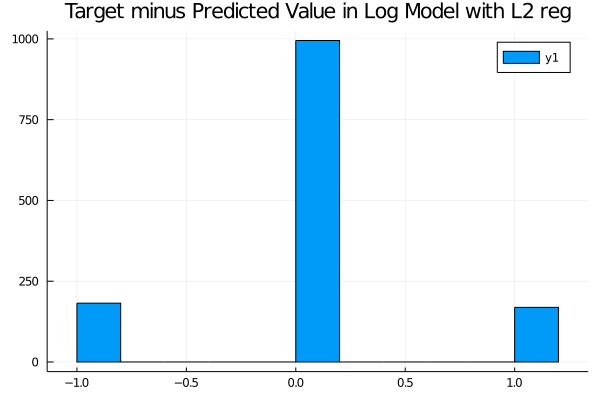

In [10]:
using ScikitLearn: fit!, predict
log_reg = fit!(LogisticRegression(penalty="l2"), xtrain, target[1:ntrain])
println("Training Set Error: ",sum(predict(log_reg,xtrain).==target[1:ntrain])/length(xtrain))
println("Testing Set Error: ",sum(predict(log_reg,xtest).==target[ntrain+1:end])/length(xtest))

histogram(target[ntrain+1:end].-predict(log_reg,xtest), title="Target minus Predicted Value in Log Model with L2 reg")

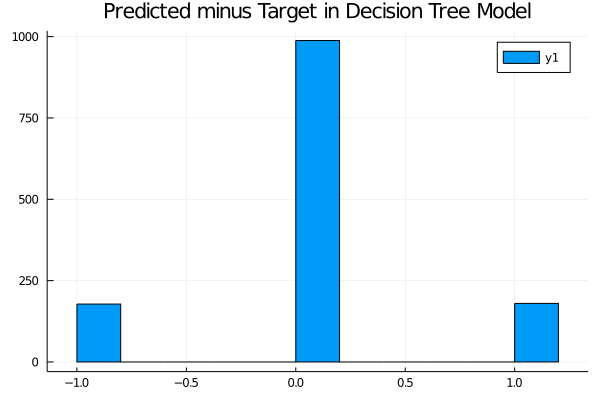

In [11]:
@sk_import ensemble: RandomForestRegressor

rf = RandomForestRegressor(random_state=69)

trees = fit!(rf, xtrain, target[1:ntrain])
predicted_dec = round.(predict(trees, xtest))

histogram(predicted_dec.-target[ntrain+1:end], title="Predicted minus Target in Decision Tree Model")

In [12]:
@sk_import inspection: permutation_importance
pimp_tree = permutation_importance(trees, xtrain, target[1:ntrain])["importances_mean"]
pimp_log = permutation_importance(log_reg, xtrain, target[1:ntrain])["importances_mean"]
imp_tree = trees.feature_importances_

imps = DataFrame(hcat(filter(col -> (col!=:dec_o), selected),pimp_log, pimp_tree, imp_tree,))
names!(imps, [:col_nm,:logmodel, :permut_tree, :tree])

,col_nm,logmodel,permut_tree,tree
,Any,Any,Any,Any
1,gender,0.00345596,0.0552449,0.014026
2,avg_attr_self,0.00141211,0.141061,0.0860213
3,avg_attr_others,0.00174656,0.315309,0.107922
4,attr_o,0.114864,0.583994,0.255244
5,age_o,-0.00234114,0.10106,0.0573184
6,sinc_o,0.00200669,0.0911143,0.0424
7,intel_o,0.00468227,0.0663822,0.0351735
8,fun_o,0.0405425,0.222617,0.0516247
9,amb_o,0.00798959,0.0765963,0.0415442


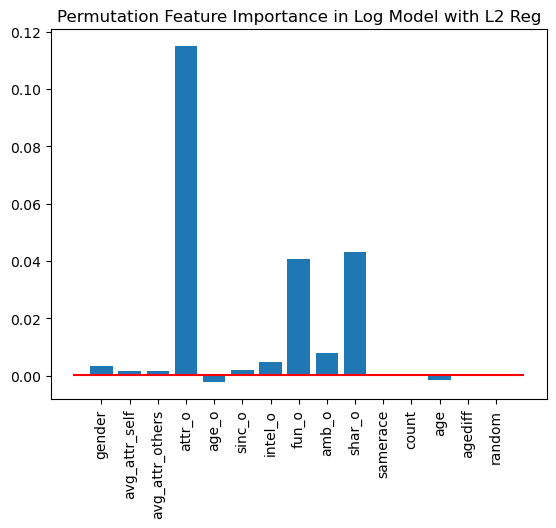

PyObject <matplotlib.collections.LineCollection object at 0x7feebda29a90>

In [13]:
#Feature Importance in Log Model with L2 Reg

PyPlot.bar(imps[:col_nm], imps[:logmodel])
xticks(0:size(imps[:col_nm],1)-1, imps[:col_nm], rotation=90)
title("Permutation Feature Importance in Log Model with L2 Reg")
PyPlot.hlines(imps[:logmodel][15], -1, 15, color="red")

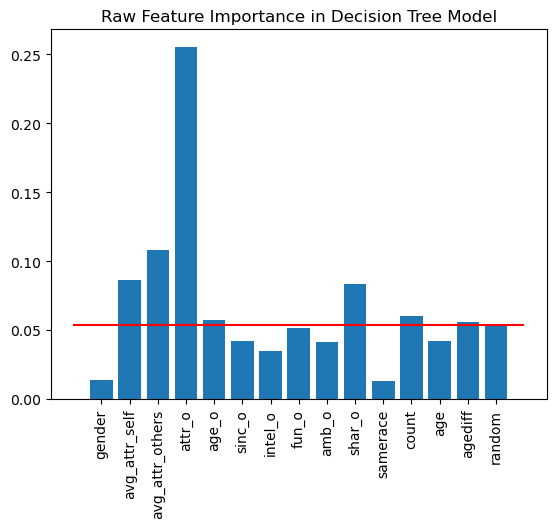

PyObject <matplotlib.collections.LineCollection object at 0x7feebde67130>

In [14]:
#Raw Feature Importance in Decision Tree Model

PyPlot.bar(imps[:col_nm], imps[:tree])
xticks(0:size(imps[:col_nm],1)-1, imps[:col_nm], rotation=90)
title("Raw Feature Importance in Decision Tree Model")
PyPlot.hlines(imps[:tree][15], -1, 15, color="red")

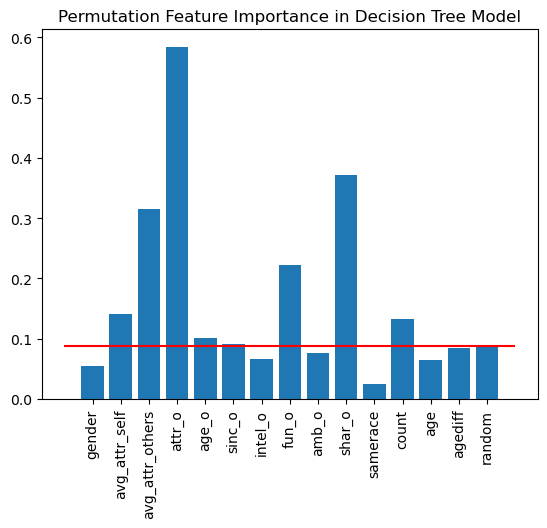

PyObject <matplotlib.collections.LineCollection object at 0x7feebe095dc0>

In [15]:
#Permutation Feature Importance in Decision Tree Model

PyPlot.bar(imps[:col_nm], imps[:permut_tree])
xticks(0:size(imps[:col_nm],1)-1, imps[:col_nm], rotation=90)
title("Permutation Feature Importance in Decision Tree Model")
PyPlot.hlines(imps[:permut_tree][15], -1, 15, color="red")

In [16]:
# THIS IS THE SCIKIT VERSION OF INTERPRETML
@sk_import inspection: plot_partial_dependence

using Pandas
py_xtrain = Pandas.DataFrame(X[1:ntrain,:])

plot_partial_dependence(trees, py_xtrain,[:intel_o])


LoadError: ArgumentError: Package Pandas not found in current path:
- Run `import Pkg; Pkg.add("Pandas")` to install the Pandas package.


In [17]:
# Redoing the models with only important features
X2 = just_attr[:, filter(col -> (col==:attr_o||col==:fun_o||col==:shar_o||col==:avg_attr_self||col==:avg_attr_others), selected)]

xtrain2 = convert(Matrix, X2[1:ntrain, :])
xtest2 = convert(Matrix, X2[ntrain+1:end, :]);

Training Set Error: 0.15046451133407654
Testing Set Error: 0.1475482912332838


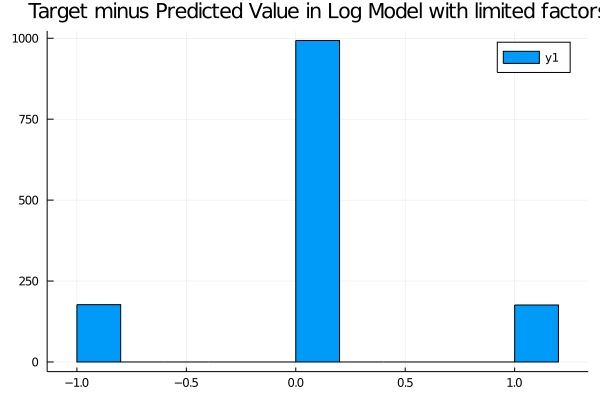

In [18]:
log_reg = fit!(LogisticRegression(penalty="none"), xtrain2, target[1:ntrain])
println("Training Set Error: ",sum(predict(log_reg,xtrain2).==target[1:ntrain])/length(xtrain2))
println("Testing Set Error: ",sum(predict(log_reg,xtest2).==target[ntrain+1:end])/length(xtest2))

histogram(target[ntrain+1:end].-predict(log_reg,xtest2), title="Target minus Predicted Value in Log Model with limited factors")

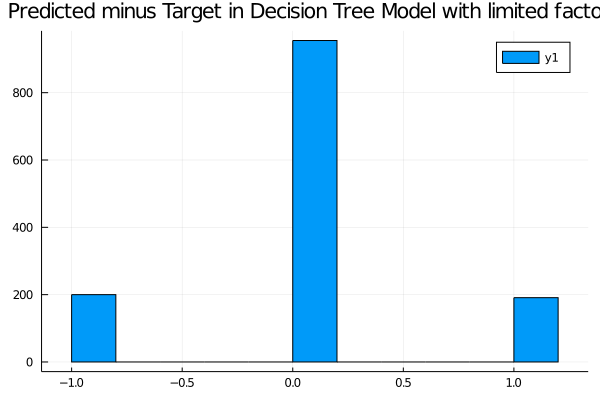

In [19]:
rf2 = RandomForestRegressor(random_state=69)

trees2 = fit!(rf2, xtrain2, target[1:ntrain])
predicted_dec2 = round.(predict(trees2, xtest2))

histogram(predicted_dec2.-target[ntrain+1:end], title="Predicted minus Target in Decision Tree Model with limited factors")

In [25]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    sqerr = (y .- pred)
    return mean(sqerr)
end

"""This completed function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This completed helper funciton plots x vs, y and labels the axes
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    StatsPlots.scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", zeromin=true)
end

LoadError: syntax: cannot juxtapose string literal

In [26]:
match_rate = just_attr |>
    @groupby(_.iid)|>
    @map({iid=key(_), rate=mean(_.dec_o)})|>
    DataFrame

match_rate = join(match_rate, just_attr, on="iid")
# Shuffle Data to ensure fair test/train split
match_rate = match_rate[shuffle(1:end), :]
#Making the split
train_proportion = 0.8
n = size(match_rate, 1)
ntrain = convert(Int, round(train_proportion*n))
println("Size of dataset: ", string(n))
println("Size of training set: ", string(ntrain))
println("Size of testing set: ", string(n-ntrain))


target = match_rate[:rate]
X = match_rate[:, filter(col -> (col==:avg_attr_others||col==:avg_attr_self), selected)]
X = hcat(X, ones(size(X,1)))
xtrain = convert(Matrix, X[1:ntrain, :])
xtest = convert(Matrix, X[ntrain+1:end, :]);

LoadError: type NamedTuple has no field iid

In [22]:
# The weights of your linear equation (compute via least squares)
w = xtrain\target[1:ntrain]

train_pred = [dot(w, xtrain[i,:]) for i in 1:size(xtrain,1)]
test_pred = [dot(w, xtest[i,:]) for i in 1:size(xtest,1)]

train_MSE = MSE(target[1:ntrain],train_pred)
test_MSE = MSE(target[ntrain+1:end],test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred,  target[ntrain+1:end])

Train MSE	-0.0025697636746862076
Test MSE 	-0.019151011530773025


LoadError: UndefVarError: plot_pred_true not defined

In [23]:
x1="Average Attractiveness Ratings of Others"
y1="Match Success Rate"
StatsPlots.scatter(match_rate[:avg_attr_others], match_rate[:rate], xlabel=x1, ylabel=y1)

LoadError: UndefVarError: match_rate not defined

In [24]:
x1="Average Attractiveness of Individual"
y1="Match Success Rate"
StatsPlots.scatter(match_rate[:avg_attr_others], match_rate[:rate], xlabel=x1, ylabel=y1)

LoadError: UndefVarError: match_rate not defined